In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeledTrainData.tsv'
UNLABELED_TRAIN_DF = BASE_DIR + 'unlabeledTrainData.tsv'
TEST_DF = BASE_DIR + 'testData.tsv'
print(os.listdir(BASE_DIR))

['word2vec_model_300dim_40minwords_10context', 'sentences_for_word2vec_convert_10.csv', 'cc.en.300.vec', 'sampleSubmission.csv', 'fasttext_embed_pretrained_cc_convert_10.sh', 'labeled_train_clean_reviews.csv', 'word2vec_model_300dim_40minwords_10context_stemmed', 'labeledTrainData.tsv', 'sentences_for_word2vec.csv', 'fasttext_300features_40minwords_10context.vec', 'labeled_train_clean_reviews_stemmed.csv', 'fasttext_300features_40minwords_10context_pretrained_cc.vec', 'test_clean_reviews_convert_10.csv', 'fasttext_300features_40minwords_10context_convert_10.vec', 'fasttext_300features_40minwords_10context.bin', 'test_submission.csv', 'fasttext_embed_pretrained_wiki.sh', 'fasttext_300features_40minwords_10context_pretrained_wiki_convert_10.bin', 'wiki-news-300d-1M.vec', 'fasttext_embed_pretrained_wiki_convert_10.sh', 'testData.tsv', 'fasttext_300features_40minwords_10context_pretrained_wiki.bin', 'cc.en.300.bin', 'test_clean_reviews_remove_stopwords.csv', 'fasttext_300features_40minword

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0, delimiter = '\t', quoting=3)
unlabeled_train = pd.read_csv(UNLABELED_TRAIN_DF, header = 0, delimiter = '\t', quoting=3)
test = pd.read_csv(TEST_DF, header = 0, delimiter = '\t', quoting=3)
print "Read %d labeled train reviews, %d unlabeled train reviews, " \
          "and %d test reviews" % (labeled_train["review"].size, unlabeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviews, 50000 unlabeled train reviews, and 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

Credits: Kaggle tutorial

In [4]:
from nltk.corpus import stopwords

def review_to_clean_review(review, remove_numbers=True):
    # Function to convert a document to a clean document,
    # optionally removing numbers.  Returns a string.
    #
    # 1. Remove HTML using lxml parser, ranked best by bs4
    review_text = BeautifulSoup(review, "lxml").get_text()
    #
    # TODO: Clean the text! stemming?
    # https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings#L92
    # https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    #  
    # 2. Remove non-letters and non-numbers
    review_text = re.sub("[^a-zA-Z0-9]", " ", review_text)
    #
    # 3. Optionally remove numbers
    if remove_numbers:
        review_text = re.sub("[0-9]", " ", review_text)
    else:
        review_text = review_text.replace('0', ' zero ')
        review_text = review_text.replace('1', ' one ')
        review_text = review_text.replace('2', ' two ')
        review_text = review_text.replace('3', ' three ')
        review_text = review_text.replace('4', ' four ')
        review_text = review_text.replace('5', ' five ')
        review_text = review_text.replace('6', ' six ')
        review_text = review_text.replace('7', ' seven ')
        review_text = review_text.replace('8', ' eight ')
        review_text = review_text.replace('9', ' nine ')
    # 6. Return a cleaned string
    return(review_text.lower())

def review_to_wordlist(review, remove_stopwords=False, remove_numbers=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    # 1. Clean review, split it into words
    words = review_to_clean_review(review).split()
    #
    # 2. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 6. Return a list of words
    return(words)

def review_to_sentences(review, tokenizer, remove_stopwords=False, remove_numbers=True):
    # Function to split a review into parsed sentences. Returns a
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(review_to_wordlist(raw_sentence, \
                                                        remove_stopwords, remove_numbers))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [5]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300  # Word vector dimensionality
MIN_WORD_COUNT = 40  # Minimum word count. Kaggle set to 40, to avoid attaching too much importance to individual movie titles.
NUM_THREADS = 4  # Number of threads to run in parallel
CONTEXT = 10  # Context window size
DOWNSAMPLING = 1e-3  # Downsample setting for frequent words
WORD2VEC_MODEL_FILE = BASE_DIR + \
    "word2vec_model_" + \
    str(EMBEDDING_DIM) + "dim_" + \
    str(MIN_WORD_COUNT) + "minwords_" + \
    str(CONTEXT) + "context"

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_FILE)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

print("Number of words in the word2vec model vocabulary: %d" % len(word2vec_model.wv.vocab))

Number of words in the word2vec model vocabulary: 16490


Prepare

In [6]:
train_clean_reviews = []
# Getting clean reviews from training set
counter = 0.
for review in labeled_train["review"]:
    clean_review = review_to_clean_review(review, remove_numbers=False)
    train_clean_reviews.append(clean_review)
    if counter % 5000. == 0.:
        print "Train review %d of %d" % (counter, len(labeled_train["review"]))
    counter = counter + 1.

# train_clean_reviews = map(
#     lambda review: review_to_clean_review(review, remove_numbers=False),
#     labeled_train["review"])

test_clean_reviews = []
# Getting clean review from testing set
counter = 0.
for review in test["review"]:
    clean_review = review_to_clean_review(review, remove_numbers=False)
    test_clean_reviews.append(clean_review)
    if counter % 5000. == 0.:
        print "Test review %d of %d" % (counter, len(test["review"]))
    counter = counter + 1.

# test_clean_reviews = map(
#     lambda review: review_to_clean_review(review, remove_numbers=False),
#     test["review"])

all_clean_reviews = train_clean_reviews + test_clean_reviews

Train review 0 of 25000
Train review 5000 of 25000
Train review 10000 of 25000
Train review 15000 of 25000
Train review 20000 of 25000
Test review 0 of 25000
Test review 5000 of 25000
Test review 10000 of 25000
Test review 15000 of 25000
Test review 20000 of 25000


In [7]:
# print(train_clean_reviews[0:2])
# print(test_clean_reviews[0:2])

In [8]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [9]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [10]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv.get_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84920


In [11]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [12]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.initializers import Constant

In [14]:
def rnn_model():
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    lstm_layer = LSTM(LSTM_UNITS, dropout=LSTM_DROPOUT, 
                      recurrent_dropout=LSTM_RECCURENT_DROPOUT)
    bilstm_layer = Bidirectional(lstm_layer)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(bilstm_layer)
    model.add(Dropout(0.2))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [15]:
lstm_model = rnn_model()

In [16]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 30,498,413
Trainable params: 85,313
Non-trainable params: 30,413,100
_________________________________________________________________


In [17]:
# batch_size: number of samples per gradient update
lstm_model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 532s 27ms/step - loss: 0.4628 - acc: 0.7843 - val_loss: 0.3546 - val_acc: 0.8560
Epoch 2/6
20000/20000 [==============================] - 529s 26ms/step - loss: 0.3731 - acc: 0.8444 - val_loss: 0.3371 - val_acc: 0.8590
Epoch 3/6
20000/20000 [==============================] - 531s 27ms/step - loss: 0.3467 - acc: 0.8564 - val_loss: 0.3151 - val_acc: 0.8716
Epoch 4/6
20000/20000 [==============================] - 531s 27ms/step - loss: 0.3610 - acc: 0.8491 - val_loss: 0.3341 - val_acc: 0.8606
Epoch 5/6
20000/20000 [==============================] - 531s 27ms/step - loss: 0.3462 - acc: 0.8560 - val_loss: 0.3261 - val_acc: 0.8622
Epoch 6/6
20000/20000 [==============================] - 530s 26ms/step - loss: 0.3226 - acc: 0.8683 - val_loss: 0.2999 - val_acc: 0.8768


In [18]:
y_test_pred_lstm = lstm_model.predict(x_test)

In [19]:
y_test_pred_binary_lstm = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred_lstm)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [21]:
print("The AUC score for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_binary_lstm))

The AUC score for LSTM model is : 0.8802.


In [23]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary_lstm})
output.to_csv(os.path.join('../', 'output', "bilstm_32units_2dropout_6epoch.csv"), index=False, quoting=3)
print "Wrote bilstm_32units_2dropout_6epoch.csv"

Wrote bilstm_32units_2dropout_6epoch.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

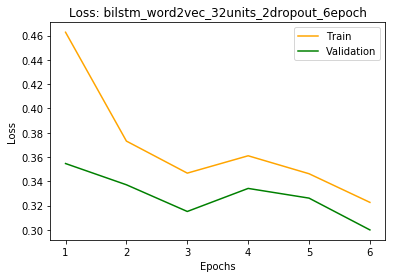

In [3]:
loss = [0.4628, 0.3731, 0.3467, 0.3610, 0.3462, 0.3226]
val_loss = [0.3546, 0.3371, 0.3151, 0.3341, 0.3261, 0.2999]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: bilstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/bilstm_word2vec_32units_2dropout_6epoch_loss.png', dpi=900)

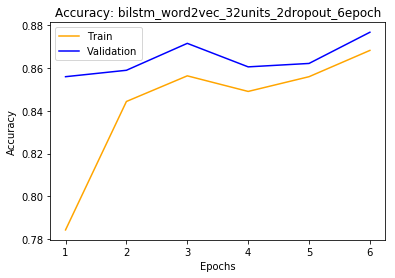

In [4]:
acc = [0.7843, 0.8444, 0.8564, 0.8491, 0.8560, 0.8683]
val_acc = [0.8560, 0.8590, 0.8716, 0.8606, 0.8622, 0.8768]

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: bilstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/bilstm_word2vec_32units_2dropout_6epoch_accuracy.png', dpi=900)